# USTC LITHO1.0
Description:
- To determine high‐resolution vp and vs models of the lithosphere of continental China, we assembled numerous high‐quality arrival‐time data from 11,953 earthquakes recorded by the China Digital Seismic Network. Double‐difference (DD) seismic tomography is applied to simultaneously determine earthquake locations and vp and vs models. Two inversion grids with grid intervals of 1° and 0.5° are sequentially used. The inverted velocity models with the coarser grid are used as the initial models for the finer grid. For the inversion with the coarser grid, the 3D vs model from ambient noise tomography and the converted vp model based on an empirical relationship between vp and vs are used as the initial models. The checkerboard resolution test shows that with the current data configuration both vp and vs models down to 150 km have a spatial resolution of 1° in the horizontal direction in most of continental China and up to 0.5° in eastern China. The inverted velocity models are further validated by arrival times from active sources and surface‐wave data. The vp model is also consistent with that along the deep seismic sounding (DSS) profile. High‐resolution vp and vs models of crust and upper mantle down to 150 km provide important constraints on tectonics beneath continental China. We name the inverted velocity models as USTClitho1.0 (Unified Seismic Tomography models for continental China lithosphere) for easy reference. Overall, our tomographic images in the shallow crust correlate well with surface geology. In the deeper part, our velocity models show some well‐known features, such as a low‐velocity layer in the middle crust beneath the Tibetan plateau (TP) and a thin lithosphere beneath the North China craton.

Reference:
- Xin, H., Zhang, H., Kang, M., He, R., Gao, L., & Gao, J. (2019). High‐resolution lithospheric velocity structure of continental china by double‐difference seismic travel‐time tomography. Seismological Research Letters, 90(1), 229–241. https://doi.org/10.1785/0220180209

Source:
- http://chinageorefmodel.org/wp-content/uploads/china-models-individual/USTClitho1.0.zip

## Step 1: Velocity Profile Extracting
1. Extracting
2. De-duplicating

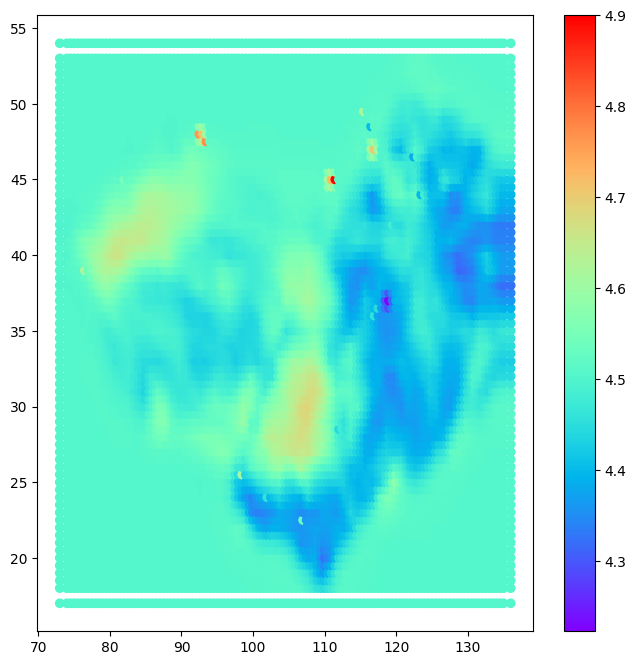

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

data_path = "../../../OpenSWI/Datasets/Original/OpenSWI-deep/USTClitho1.0/data/vs"
data_file_list = sorted(os.listdir(data_path), key=lambda x: int(x.split(".")[0].replace("Z_vs", "")))

depth = []
datas = []
for data_file in data_file_list:
    depth.append(int(data_file.split(".")[0].replace("Z_vs", "")))
    data_file_path = os.path.join(data_path, data_file)
    data = np.loadtxt(data_file_path)
    datas.append(data)

depth = np.array(depth)
datas = np.array(datas)

lons = datas[0,:,0]
lats = datas[0,:,1]
vs = datas[:,:,2].T
locs = np.vstack((lons, lats)).T

plt.figure(figsize=(8, 8))
depths_idx = 10
plt.scatter(locs[:,0],locs[:,1],c=vs[:,depths_idx],cmap="rainbow")
plt.colorbar()
plt.show()


## Step 2: Quality Control & Interpolation

1. interpolation

2. rationalizing (remove the thin layers)


In [ ]:
import sys
sys.path.append('../../../')
from SWIDP.process_1d_deep import *
from SWIDP.dispersion import *

In [3]:
vs.shape,depth.shape

((9125, 12), (12,))

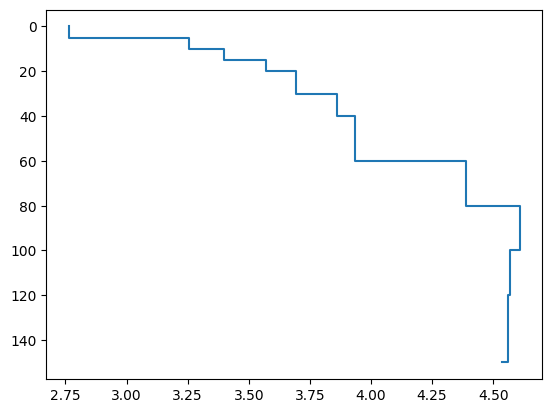

In [4]:
plt.figure()
sta_idx = 1000
plt.step(vs[sta_idx,:],depth)
plt.gca().invert_yaxis()
plt.show()

In [5]:
# -------------------------------------------------------
#  interp to 1 km thickness
# -------------------------------------------------------

from scipy.interpolate import interp1d
max_depth = 300+0.1
depth_interp = np.concatenate([
    np.arange(0, max_depth, 1)
])
vs_models = vs_interp = np.zeros((vs.shape[0],depth_interp.shape[0]))
for i in range(vs.shape[0]):
    vs_temp = vs[i,:]
    depth_interp_temp = depth_interp[:np.argmin(np.abs(depth_interp-depth.max()))]
    f = interp1d(depth.reshape(-1),vs_temp,kind='nearest')
    vs_temp = f(depth_interp_temp)
    vs_interp[i,:len(vs_temp)] = vs_temp
vs_interp[:,len(vs_temp):] = vs_interp[:,len(vs_temp)-1].reshape(-1,1)
vs_interp.shape

(9125, 301)

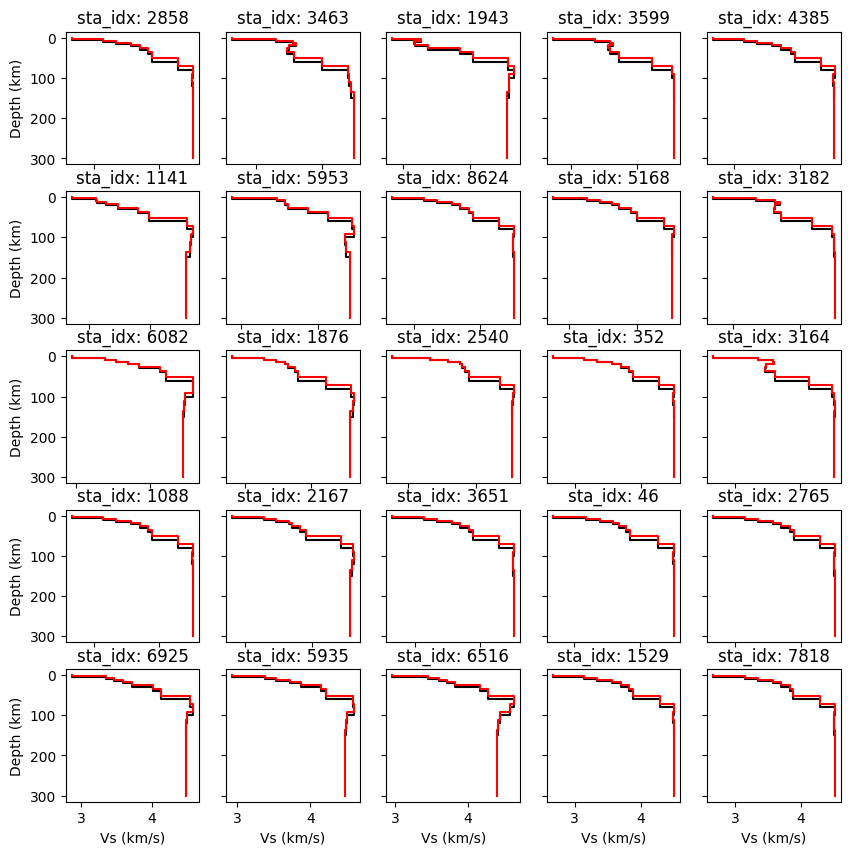

In [6]:
nrows = 5
ncols = 5
fig,axs = plt.subplots(nrows,ncols,figsize=(10,10))
for i in range(nrows):
    for j in range(ncols):
        sta_idx = np.random.randint(0,len(vs))
        axs[i,j].step(vs[sta_idx,:],depth,c='k')
        axs[i,j].step(vs_interp[sta_idx,:],depth_interp,c='r')
        axs[i,j].invert_yaxis()
        axs[i,j].set_title(f'sta_idx: {sta_idx}')
        if j == 0:
            axs[i,j].set_ylabel('Depth (km)')
        else:
            axs[i,j].tick_params(labelleft=False)
        if i == nrows-1:
            axs[i,j].set_xlabel('Vs (km/s)')
        else:
            axs[i,j].tick_params(labelbottom=False)
plt.show()

In [10]:
# -------------------------------------------------------
#  remove the sandwich layers
# -------------------------------------------------------
from p_tqdm import p_map
# process all the stations
vs_interp_rm_sandwich = p_map(combine_thin_sandwich,
                            vs_interp,
                            list(depth_interp.reshape(1,-1))*len(vs_interp),
                            [12]*len(vs_interp),
                            [1]*len(vs_interp),
                            [0.05]*len(vs_interp),
                            [False]*len(vs_interp))

# find the moho depth
vs_interp_rm_sandwich = np.array(vs_interp_rm_sandwich)
vs_interp_rm_sandwich.shape


  0%|          | 0/9125 [00:00<?, ?it/s]

(9125, 301)

In [11]:
# -------------------------------------------------------
#  Smooth velocity model (B spline/Pchip)
# -------------------------------------------------------
from p_tqdm import p_map
# process all the stations
vs_interp_rm_sandwich = p_map(smooth_vs_by_node_interp,
                            vs_interp_rm_sandwich,
                            list(depth_interp.reshape(1,-1))*len(vs_interp_rm_sandwich),
                            [20]*len(vs_interp_rm_sandwich),
                            ["pchip"]*len(vs_interp_rm_sandwich))

# find the moho depth
vs_interp_rm_sandwich = np.array(vs_interp_rm_sandwich)
vs_interp_rm_sandwich.shape


  0%|          | 0/9125 [00:00<?, ?it/s]

(9125, 301)

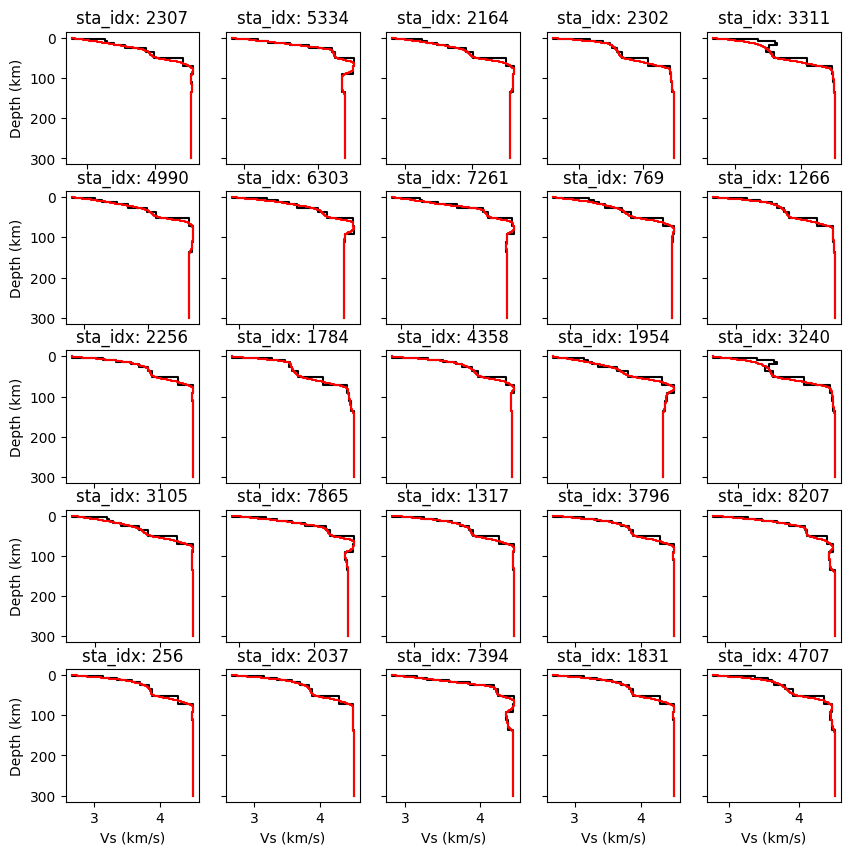

In [12]:
nrows = 5
ncols = 5
fig,axs = plt.subplots(nrows,ncols,figsize=(10,10))
for i in range(nrows):
    for j in range(ncols):
        sta_idx = np.random.randint(0,len(vs))
        axs[i,j].step(vs_interp[sta_idx,:],depth_interp,c='k')
        axs[i,j].step(vs_interp_rm_sandwich[sta_idx,:],depth_interp,c='r')
        axs[i,j].invert_yaxis()
        axs[i,j].set_title(f'sta_idx: {sta_idx}')
        if j == 0:
            axs[i,j].set_ylabel('Depth (km)')
        else:
            axs[i,j].tick_params(labelleft=False)
        if i == nrows-1:
            axs[i,j].set_xlabel('Vs (km/s)')
        else:
            axs[i,j].tick_params(labelbottom=False)
plt.show()

## Step 3: Dispersion Curve Forward Modeling

In [13]:
vs_models = vs_interp_rm_sandwich.reshape(-1,vs_interp_rm_sandwich.shape[-1]) # [n_models,n_depth]
depth_models = list(depth_interp.reshape(1,-1))*len(vs_models)
vel_models = p_map(transform_vs_to_vel_model,vs_models,depth_models)
vel_models = np.array(vel_models)
vel_models.shape

  0%|          | 0/9125 [00:00<?, ?it/s]

(9125, 301, 4)

In [14]:
# Calculate dispersion curves
t = generate_mixed_samples(num_samples=300,start=1,end=100,uniform_num=100,log_num=100,random_num=100)
t = np.ones((len(vel_models),len(t)))*t
disp_data = p_map(calculate_dispersion, vel_models, list(t))
disp_data = np.array(disp_data)
vel_models = np.array(vel_models)
vel_models.shape,disp_data.shape

  0%|          | 0/9125 [00:00<?, ?it/s]

((9125, 301, 4), (9125, 300, 3))

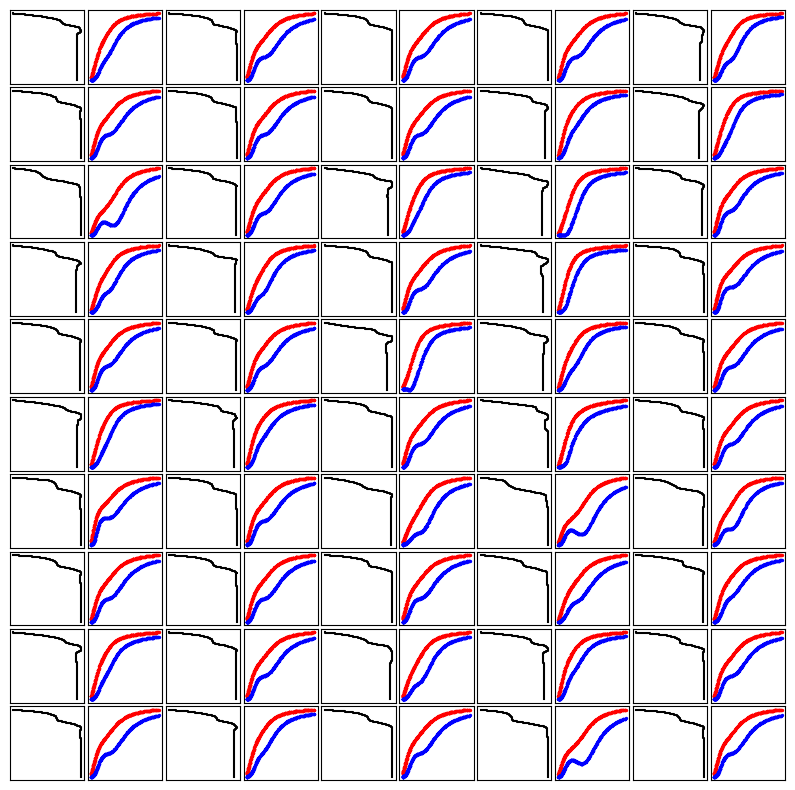

In [15]:
nrows = 10
ncols = 10
fig,axs = plt.subplots(nrows,ncols,figsize=(10,10))

for i in range(nrows):
    for j in range(ncols//2):

        sta_idx = np.random.randint(0,vel_models.shape[0])

        # velocity profile
        axs[i,j*2].step(vel_models[sta_idx][:,2],vel_models[sta_idx][:,0],c='k')
        axs[i,j*2].set_xticks([])
        axs[i,j*2].set_yticks([])
        axs[i,j*2].invert_yaxis()

        # dispersion curve
        axs[i,j*2+1].scatter(disp_data[sta_idx][:,0],disp_data[sta_idx][:,1],s=2,c='r')
        axs[i,j*2+1].scatter(disp_data[sta_idx][:,0],disp_data[sta_idx][:,2],s=2,c='b')
        axs[i,j*2+1].set_xticks([])
        axs[i,j*2+1].set_yticks([])
plt.subplots_adjust(wspace=0.05,hspace=0.05)
plt.show()

In [9]:
phase_mask = np.sum(disp_data[:,:,1] == 0,axis=1)==0
group_mask = np.sum(disp_data[:,:,2] == 0,axis=1)==0
mask = phase_mask*group_mask

loc = np.hstack((lons.reshape(-1,1),lats.reshape(-1,1)))[mask,:]
vel_models = vel_models[mask,:,:]
disp_data = disp_data[mask,:,:]

In [ ]:
import os
save_base_path = "../../../OpenSWI/Datasets/OpenSWI-deep/1s-100s-Base"
# Save processed data as compressed npz files
np.savez_compressed(os.path.join(save_base_path, "USTCLitho1_loc.npz"),
                    data=loc.astype(np.float32))
np.savez_compressed(os.path.join(save_base_path, "USTCLitho1_model.npz"),
                    data=vel_models.astype(np.float32))
np.savez_compressed(os.path.join(save_base_path, "USTCLitho1_disp.npz"),
                    data=disp_data.astype(np.float32))